<a href="https://colab.research.google.com/github/dawidplotka-analyst/Ecommerce-Conversion-Analysis/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import google.colab.auth
from google.colab import drive

#dostęp do mojego drive
drive.mount('/content/drive')

# Authenticate user to Google Cloud
google.colab.auth.authenticate_user()

#importuje baze danych z BigQuery:
baza = bigquery.Client(project="data-analytics-mate")

#za pomocą kodu SQL poniżej wypisanego, przygotowuję sobie gotową tabele, na której będę pracował:

sql = """
SELECT
s.date AS `order date`,
s.ga_session_id AS `session ID`,
continent,
country,
device,
browser,
mobile_model_name AS `device model name`,
operating_system AS `operating system`,
language AS `browser language`,
medium AS `traffic source information`,
channel AS `traffic channel`,
ac.id AS `registered user ID`,
is_verified AS `is veriffied account`,
is_unsubscribed AS `is unsubscribed account`,
p.category AS `product category`,
p.name AS `product name`,
price,
short_description AS `short description`
FROM `DA.session` AS s
JOIN `DA.session_params` AS sp
USING(ga_session_id)
LEFT JOIN `DA.account_session` AS acs
USING(ga_session_id)
LEFT JOIN `DA.account` AS ac
ON acs.account_id = ac.id
LEFT JOIN `DA.order` AS o
USING(ga_session_id)
LEFT JOIN `DA.product` AS p
USING(item_id)

"""

tabela_bazowa = baza.query(sql).to_dataframe()
print(tabela_bazowa.head())

#Podstawowe informacje, liczba wierszy, ile null i dlaczego, sprawdzenie zgodności typów danych
print(tabela_bazowa.describe())
print(tabela_bazowa.info())
print(f"Liczba unikalnych wierszy: {tabela_bazowa['session ID'].nunique()}")
print(tabela_bazowa.isnull().sum())
print(f"Kolumny numeryczne: {tabela_bazowa.select_dtypes(include=['int64', 'float64']).columns.tolist()}")
kategoryczne = tabela_bazowa.select_dtypes(include=['object']).columns.tolist()
print("Kolumny kategoryczne:", *kategoryczne, sep='\n')
print(len(kategoryczne))

#Zakres dat
print(tabela_bazowa['order date'].min())
print(tabela_bazowa['order date'].max())

#wielkość tabli
print(f"Wielkość tabeli: {tabela_bazowa.shape}")

#Podstawowe sprawy sprawdzone w Python, reszta działań w TABLEAU, poniżej eksport pliku do csv:

#eksport na komputer
tabela_bazowa.to_csv('tabela_bazowa.csv', index=False)

#eksport na drive
path = '/content/drive/MyDrive/Colab Notebooks/tabela_bazowa.csv'
tabela_bazowa.to_csv(path, index=False)

Mounted at /content/drive
   order date  session ID continent         country   device browser  \
0  2020-11-01  5760483956  Americas   United States  desktop  Chrome   
1  2020-11-01  7115337200    Europe  United Kingdom  desktop  Chrome   
2  2020-11-01  3978035233    Europe          Norway   mobile  Chrome   
3  2020-11-01  9648986282    Africa         Nigeria   mobile  Chrome   
4  2020-11-01  4393441533      Asia           China  desktop  Chrome   

  device model name operating system browser language  \
0            Safari        Macintosh               zh   
1            Chrome              Web            en-us   
2           <Other>              Web               zh   
3           <Other>          Android            es-es   
4            Chrome          Windows            en-us   

  traffic source information traffic channel  registered user ID  \
0                    <Other>     Paid Search                <NA>   
1                    organic  Organic Search                <N

## 🏗️ 1. Skala i Zakres Danych
Zbiór danych obejmuje aktywność użytkowników w okresie 3 miesięcy. Kluczową cechą bazy jest jej unikalność na poziomie sesji.

* **Całkowita liczba wierszy:** `349 545`
* **Unikalne sesje (Session ID):** `349 545` (Każdy rekord to osobna sesja)
* **Liczba kolumn:** `18`
* **Zakres czasowy:** `2020-11-01` — `2021-01-31`

---

&nbsp;
## 📂 2. Struktura Kolumn (Segmentacja)


| Typ Kolumny | Liczba | Nazwy Kolumn |
| :--- | :---: | :--- |
|
| **Kategoryczne** | **12** | `continent`, `country`, `browser`, `device model name`, `operating system`, `browser language`, `traffic source information`, `traffic channel`, `product category`, `product name`, `short description` |
| **Numeryczne** | **5** | `session ID`, `registered user ID`, `is veriffied account`, `is unsubscribed account`, `price` |
| **Daty** | **1** | `order date` |

---
&nbsp;

## 🔍 3. Analiza Brakujących Wartości (Data Quality)

Znaczna liczba wartości `NULL` wynika z charakteru bazy – łączy ona dane o ogólnym ruchu na stronie z danymi o zakupach i zarejestrowanych kontach.



| Kolumna | Liczba braków (NaN) | Procent (%) | Interpretacja Biznesowa |
| :--- | :--- | :---: | :--- |
|      
| **registered user ID** | 321 600 | **~92%** | Większość to ruch anonimowy (goście). |
| **is veriffied account** | 321 600 | **~92%** | Dotyczy tylko zarejestrowanych użytkowników. |
| **product category** | 316 007 | **~90%** | Sesje bez interakcji z konkretnym produktem. |
| **price** | 316 007 | **~90%** | Sesje, które nie zakończyły się transakcją. |
| **browser language** | 114 266 | **~33%** | Brak danych technicznych z przeglądarki. |


---
&nbsp;

## 💡 Kluczowe Wnioski
1.  **Konwersja:** Tylko ok. **10%** sesji zawiera dane o produktach i cenach, co sugeruje, że pozostałe 90% to sesje "przeglądowe" bez dodania do koszyka.
2.  **Użytkownicy:** Baza jest zdominowana przez użytkowników bez kont (~92%). Analiza zachowań subskrybentów będzie dotyczyć tylko wąskiej, wyselekcjonowanej grupy.
3.  **Spójność:** `Session ID` jest idealnym kluczem głównym – każdy wiersz to unikatowe zdarzenie.

## 📊 DASHBOARD #1
Link do dashboardu: [Sales Comparision](https://public.tableau.com/views/Salescomparison_17700312446790/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

# 💡 Wnioski
## 1. Precyzyjna Sezonowość i Dynamika

Na wykresie GENERAL widać wyraźne cykle.

**Listopad:** W analizowanym okresie 3 listopada odnotowano pierwszy znaczący skok sprzedaży (ok. 500k), który miał charakter incydentalny. Sprzedaż wzrosła dwukrotnie względem poziomu bazowego z początku miesiąca w ciągu zaledwie 48h, co wskazuje na skuteczną, krótką akcję promocyjną.

**Grudzień:** "Okres 6–19 grudnia to nie tylko 'święta', ale najdłuższy w skali kwartału cykl wysokiej sprzedaży. Zaczyna się on gwałtownym wybiciem ok. 8 grudnia (peak powyżej 600k), po którym następuje seria trzech kolejnych szczytów, co sugeruje utrzymanie wysokiego popytu przez pełne dwa tygodnie przedświąteczne".

**Styczeń** (Efekt odbicia): "Wzrost w dniach 1–8 stycznia charakteryzuje się dużą amplitudą – po najniższym punkcie w roku (okolice 25 grudnia), sprzedaż gwałtownie odbija, osiągając blisko 600k w pierwszym tygodniu stycznia. Jest to klasyczna sezonowość poświąteczna/noworoczna".

## 2. Kontynenty – Skala i Udział
**Wniosek:** "Ameryka (czerwona linia) dominuje, generując w szczytach (grudzień) tyle samo sprzedaży, co Azja i Europa łącznie. Choć trendy są zbieżne, Ameryka wykazuje znacznie wyższą zmienność (większe skoki), co oznacza, że jest to rynek najbardziej reaktywny na promocje".

## 3. Traffic Channel – Analiza Liderów i Maruderów

- Organic Search (Pomarańczowy): "To kluczowy kanał wzrostu. W grudniu to właśnie Organic Search najsilniej zareagował na trend rosnący, osiągając peak w okolicach 250k. Wykazuje on najwyższą korelację z ogólnym wynikiem sprzedaży".

- Social Search (Morski): "Kanał ten wykazuje brak reaktywności na sezonowość. Podczas gdy inne kanały potroiły swoje wyniki w grudniu, Social Search pozostał na niemal płaskim poziomie (okolice 50k). Potwierdza to niską efektywność tego źródła w generowaniu sprzedaży w kluczowych okresach".

## 4. Device – Dominacja Desktopu

**Skala:** Desktop (granatowy) jest wyraźnie nad Mobile (pomarańczowy).

**Wniosek:** "Wbrew pozorom, Desktop dominuje nad Mobile w każdym punkcie czasowym, generując średnio o ok. 30-40% wyższe przychody. Szczególnie w szczytach sprzedaży (grudzień, styczeń) dystans między Desktopem a Mobile powiększa się, co sugeruje, że klienci preferują finalizację większych zakupów na komputerach. Tablet jest kanałem nieznaczącym (płaska linia blisko zera)".

##📊 Interaktywny podgląd danych

###⚠️ Uwaga:
Poniższa tabela jest osadzoną ramką Google Sheets. Jeśli przeglądasz ten projekt bezpośrednio na GitHubie, tabela może nie wyświetlać się poprawnie ze względów bezpieczeństwa przeglądarki.

Aby zobaczyć pełną, interaktywną macierz danych, kliknij przycisk "Open in Colab" na samej górze strony

In [ ]:
from IPython.display import IFrame

url = "https://docs.google.com/spreadsheets/d/1rnXz0Q6W_pRwL5S2JF39z-so6GP4GoQL8tt2DSvGGP4/preview"

IFrame(url, width=600, height=200)

## Analiza Dystrybucji Ruchu (Kanały vs. Urządzenia)
Na podstawie powyższej tabeli przestawnej można sformułować następujące wnioski dotyczące zachowań użytkowników i efektywności kanałów marketingowych:

**Dominacja Desktopu w Ruchu Organicznym:** Najsilniejszym punktem styku z klientem jest Organic Search na urządzeniach typu Desktop (72 622 sesje). Świadczy to o silnej pozycji marki w wyszukiwarkach i fakcie, że użytkownicy wolą przeglądać ofertę na większych ekranach.

**Wysoka Skuteczność Płatnych Działań (Paid Search):** Ruch płatny generuje łącznie ponad 92 tys. sesji, z czego większość (ok. 60%) pochodzi z komputerów. To sugeruje, że kampanie PPC są dobrze zoptymalizowane pod użytkowników stacjonarnych.

**Potencjał Mobile:** Urządzenia mobilne odpowiadają za znaczącą część ruchu (łącznie ponad 68 tys. sesji w trzech głównych kanałach). Wskazuje to na konieczność zapewnienia najwyższej jakości doświadczenia zakupowego (UX) na smartfonach.

**Niszowe Znaczenie Tabletów:** We wszystkich kanałach ruch z tabletów jest marginalny (średnio ok. 2-3 tys. sesji na kanał). W kontekście alokacji budżetu na optymalizację strony, urządzenia te powinny mieć najniższy priorytet.

**Źródła Bezpośrednie (Direct): **Solidna liczba sesji w kanale Direct na Desktopie (34 496) świadczy o dobrej rozpoznawalności marki – klienci wpisują adres strony bezpośrednio w przeglądarkę.

🔗 [Kliknij tutaj, aby otworzyć interaktywny Tabele na GoogleSheet](https://docs.google.com/spreadsheets/d/1rnXz0Q6W_pRwL5S2JF39z-so6GP4GoQL8tt2DSvGGP4/edit?usp=sharing)

## Analiza globalnej sprzedaży (Tableau)
Aby dokładnie zbadać strukturę przychodów, przygotowałem Heatmap w programie Tableau. Wizualizacja skupia się na 10 najpopularniejszych kategoriach produktów w 5 krajach o najwyższej sprzedaży.

🔗 [Kliknij tutaj, aby otworzyć interaktywny dashboard na Tableau Public](https://public.tableau.com/views/Salescomparison_17700312446790/Dashboard2?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

## 💡 Kluczowe wnioski i obserwacje biznesowe
**Dominacja rynku:** Stany Zjednoczone są bezsprzecznym liderem przychodów, generując najwyższe wolumeny sprzedaży w niemal każdej analizowanej kategorii produktów.

**Bestseller globalny: **Kategoria 'Sofas & armchairs' (Sofy i fotele) to główny motor wzrostu. Na mapie cieplnej wykazuje ona najwyższą gęstość sprzedaży we wszystkich kluczowych regionach.

**Specjalizacja regionalna:** Mimo ogólnej dominacji USA, rynki takie jak Kanada i Wielka Brytania wykazują silną pozycję w kategoriach 'Beds' (Łóżka) oraz 'Bookcases & shelving units' (Regały i półki), co sugeruje duży potencjał dla produktów do organizacji domu w tych krajach.

**Obszary do optymalizacji:** Kategorie takie jak 'Outdoor furniture' (Meble ogrodowe) czy 'Bar furniture' (Meble barowe) radzą sobie znacznie słabiej na rynkach europejskich (Francja/Niemcy) w porównaniu do Ameryki Północnej. Może to wskazywać na potrzebę dostosowania marketingu lub optymalizacji asortymentu w tych regionach.


Granica górna (Upper Bound) [price]: 603049.06
Liczba dni z ekstremalną sprzedażą [price]: 3
Granica górna (Upper Bound) [price]: 95279.36
Liczba dni z ekstremalną sprzedażą [price]: 4
Granica górna (Upper Bound) [session ID]: 6301.25
Liczba dni z ekstremalną sprzedażą [session ID]: 1
Granica górna (Upper Bound) [session ID]: 1277.25
Liczba dni z ekstremalną sprzedażą [session ID]: 0


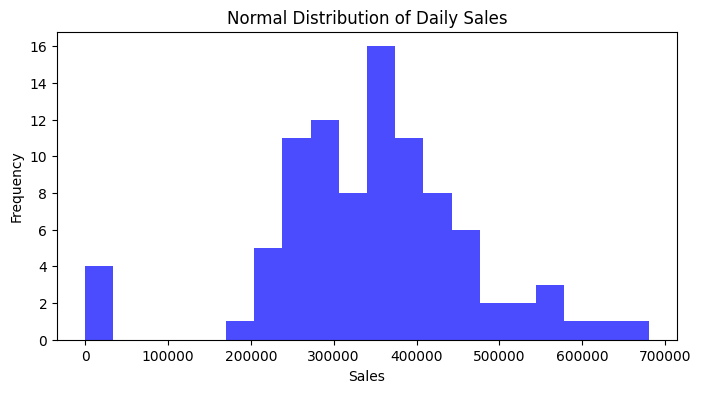

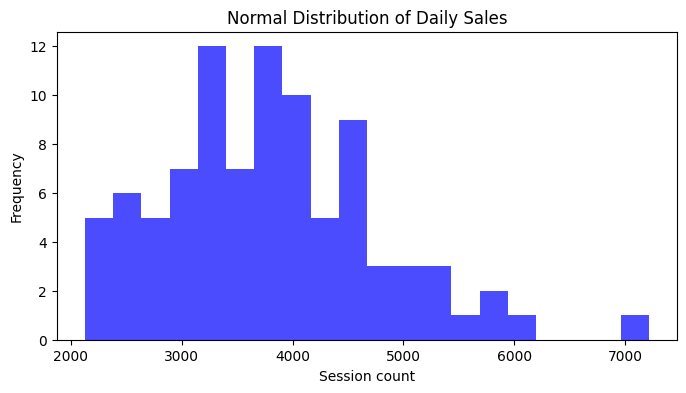

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
daily_stats = tabela_bazowa.groupby('order date').agg({'session ID':'nunique', 'price': 'sum'}).reset_index().sort_values('order date')
daily_stats.head(10)

#Sprawdzam outliers dla price:
# 1. Obliczanie kwartyli
Q1 = daily_stats['price'].quantile(0.25)
Q3 = daily_stats['price'].quantile(0.75)

# 2. Obliczanie rozstępu międzykwartylowego (IQR)
IQR = Q3 - Q1

# 3. Definiowanie granic dla Outlierów (tzw. płoty Tukeya)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Znalezienie konkretnych dni, które są outlierami
outliers_up = daily_stats[daily_stats['price'] > upper_bound]
outliers_down = daily_stats[daily_stats['price'] < lower_bound]
print(f"Granica górna (Upper Bound) [price]: {upper_bound:.2f}")
print(f"Liczba dni z ekstremalną sprzedażą [price]: {len(outliers_up)}")
print(f"Granica górna (Upper Bound) [price]: {lower_bound:.2f}")
print(f"Liczba dni z ekstremalną sprzedażą [price]: {len(outliers_down)}")

#Sprawdzam outliers dla session ID:
# 1. Obliczanie kwartyli
Q1 = daily_stats['session ID'].quantile(0.25)
Q3 = daily_stats['session ID'].quantile(0.75)

# 2. Obliczanie rozstępu międzykwartylowego (IQR)
IQR = Q3 - Q1

# 3. Definiowanie granic dla Outlierów
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Znalezienie konkretnych dni, które są outlierami
outliers_up = daily_stats[daily_stats['session ID'] > upper_bound]
outliers_down = daily_stats[daily_stats['session ID'] < lower_bound]
print(f"Granica górna (Upper Bound) [session ID]: {upper_bound:.2f}")
print(f"Liczba dni z ekstremalną sprzedażą [session ID]: {len(outliers_up)}")
print(f"Granica górna (Upper Bound) [session ID]: {lower_bound:.2f}")
print(f"Liczba dni z ekstremalną sprzedażą [session ID]: {len(outliers_down)}")

#sprawdzę rozkład, zeby użyć odpowiedniej metody sprawdzenia korelacji price
plt.figure(figsize=(8, 4))
plt.hist(daily_stats['price'], bins=20, color="blue", alpha=0.7)
plt.title("Normal Distribution of Daily Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

#sprawdzę rozkład, zeby użyć odpowiedniej metody sprawdzenia korelacji session ID
plt.figure(figsize=(8, 4))
plt.hist(daily_stats['session ID'], bins=20, color="blue", alpha=0.7)
plt.title("Normal Distribution of Daily Sales")
plt.xlabel("Session count")
plt.ylabel("Frequency")
plt.show()

Po sprawdzeniu danych odstających i rozkłądu, do sprawdzenia korelacji użyje metody Spearmana, ponieważ mamy odstające dane oraz asymetrie w rozkłądzie z ogonem po prawj stronie

In [ ]:
from scipy.stats import spearmanr

corr, p_value = spearmanr(daily_stats['session ID'], daily_stats['price'])

print(f"Współczynnik korelacji Spearmana: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

Współczynnik korelacji Spearmana: 0.8653
P-value: 0.0000


# 💡 Wnioski

Analiza wykazała silną ($r_s = 0.86$) i wysoce istotną statystycznie ($p < 0.001$) zależność między liczbą sesji a przychodem. W kontekście analizy finansowej oznacza to, że model biznesowy jest skalowalny – każda jednostka ruchu przekłada się na przewidywalny wzrost sprzedaży, a ryzyko, że relacja ta jest przypadkowa, jest pomijalne.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import spearmanr
daily_stats = tabela_bazowa.groupby(['order date','traffic channel'])['price'].sum().reset_index().sort_values('order date')
daily_stats = daily_stats[daily_stats['traffic channel'] != 'Undefined']
daily_stats.head(10)
#Rozkład sprwadzę za pomocą Testu Shapiro-Wilka, dla każdego z traffic channel
for channel in daily_stats['traffic channel'].unique():
  chanel_sum_price = daily_stats[daily_stats['traffic channel'] == channel]['price']
  statistic, p_value = shapiro(chanel_sum_price)
  print(f"\nStatistic {channel}: {statistic:.4f}")
  print(f"P-value {channel}: {p_value:.4f}")
for channel in daily_stats['traffic channel'].unique():
  chanel_sum_price = daily_stats[daily_stats['traffic channel'] == channel]['price']
  print(f'\n{channel}:\nmean:{chanel_sum_price.mean()},\nmedian: {chanel_sum_price.median()}')

korelacje = daily_stats.pivot_table(index='order date', columns='traffic channel', values='price').corr(method='spearman')

print(korelacje)
korelacje.to_csv('korelacje.csv')



Statistic Direct: 0.9650
P-value Direct: 0.0144

Statistic Organic Search: 0.9479
P-value Organic Search: 0.0011

Statistic Paid Search: 0.9599
P-value Paid Search: 0.0064

Statistic Social Search: 0.9842
P-value Social Search: 0.3347

Direct:
mean:81466.55869565217,
median: 81952.15

Organic Search:
mean:124273.38695652176,
median: 119661.0

Paid Search:
mean:92511.40652173913,
median: 91170.0

Social Search:
mean:27522.88804347826,
median: 27207.85
traffic channel    Direct  Organic Search  Paid Search  Social Search
traffic channel                                                      
Direct           1.000000        0.779663     0.729369       0.469342
Organic Search   0.779663        1.000000     0.793381       0.461543
Paid Search      0.729369        0.793381     1.000000       0.492725
Social Search    0.469342        0.461543     0.492725       1.000000


# 💡 Wnioski
Choć współczynniki testu Shapiro-Wilka były wysokie (powyżej 0.95), duża liczebność próby pozwoliła wykryć subtelne odstępstwa od normalności ($p < 0.05$). W takiej sytuacji, zamiast naciągać rzeczywistość do modelu normalnego, świadomie wybrałem metodę Spearmana jako bardziej bezpieczną.

Analiza korelacji Spearmana wykazała krytyczną synergię między Paid i Organic Search ($r = 0,79$). Sugeruje to, że inwestycja w płatne linki wspiera konwersję w kanale bezpłatnym. Z kolei Social Search wykazuje niską współzależność z resztą kanałów, co wskazuje na unikalny profil klienta w tym segmencie.

[Kliknij tutaj, aby otworzyć interaktywny dashboard na Tableau Public Spearman Correlation Matrix Heatmap & Sales Correlation](https://public.tableau.com/views/SpearmanCorrelationMatrixHeatmap/SpearmanCorrelationMatrixHeatmapSalesCorrelation?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

Sprawdzam, czy różnica w przychodach od grupy zarejestrowanych do niezarejestrowanych ma statystyczne potr=wierdzenie

<IntegerArray>
[  <NA>, 649280, 676055, 677981, 672927, 653089, 652773, 661871, 654307,
 652752,
 ...
 667646, 678714, 648381, 642782, 649885, 652887, 675528, 660454, 647640,
 637845]
Length: 27946, dtype: Int64
        order date  is_registred  price
0       2020-11-01         False  609.0
1       2020-11-01         False  609.0
2       2020-11-01         False  189.0
3       2020-11-01         False  609.0
4       2020-11-01         False  609.0
...            ...           ...    ...
349540  2021-01-31         False    NaN
349541  2021-01-31         False    NaN
349542  2021-01-31         False    NaN
349543  2021-01-31         False    NaN
349544  2021-01-31         False    NaN

[349545 rows x 3 columns]
1      21547.0
3      44956.8
5      29150.5
7      20982.2
9      25334.6
        ...   
167    16117.0
169    20914.0
171    34163.8
173    27213.6
175    14613.6
Name: price, Length: 88, dtype: float64

0      222745.5
2      310550.0
4      469829.1
6      318204.9
8      3659

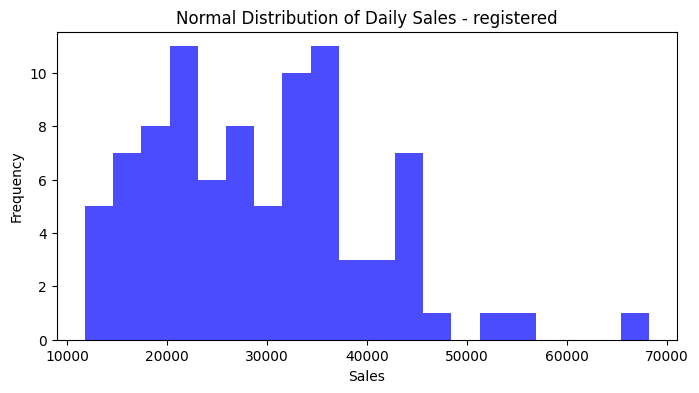

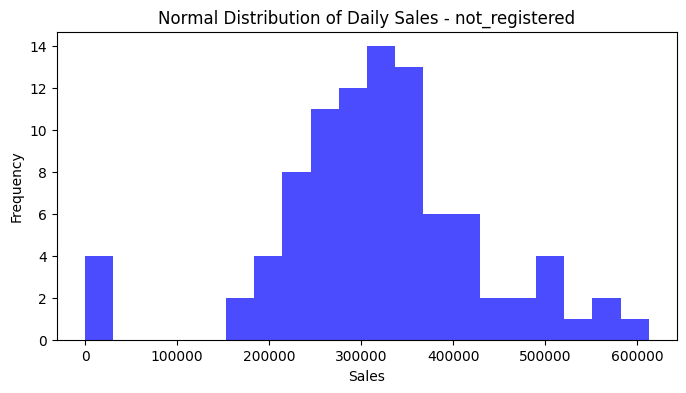

Shapiro-Wilk dla zarejestrowanych: ShapiroResult(statistic=np.float64(0.9591810175035426), pvalue=np.float64(0.007295139880540744))
Shapiro-Wilk dla niezarejestrowanych: ShapiroResult(statistic=np.float64(0.9487769113384333), pvalue=np.float64(0.0012184604855253293))


In [ ]:
print(tabela_bazowa['registered user ID'].unique())
tabela_bazowa['is_registred'] = tabela_bazowa['registered user ID'].notna()
#print(tabela_bazowa)
is_registered = tabela_bazowa[['order date', 'is_registred', 'price']]
print(is_registered)
# grupuje po dacie dla false i true dla zarejestrowanych sumując price

grouped_is_registered = is_registered.groupby(['order date', 'is_registred'])['price'].sum().reset_index()

#rozdzielam na true i fals tworzac dwie tabele do sprawdzenia rozkładu

registered = grouped_is_registered[grouped_is_registered['is_registred'] == True]['price']
not_registered = grouped_is_registered[grouped_is_registered['is_registred'] == False]['price']
print(registered)
print(f'\n{not_registered}')

#sprawdzę rozkład, zeby użyć odpowiedniej metody sprawdzenia korelacji price, dla registered
plt.figure(figsize=(8, 4))
plt.hist(registered, bins=20, color="blue", alpha=0.7)
plt.title("Normal Distribution of Daily Sales - registered")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

#sprawdzę rozkład, zeby użyć odpowiedniej metody sprawdzenia korelacji price, dla not_registered
plt.figure(figsize=(8, 4))
plt.hist(not_registered, bins=20, color="blue", alpha=0.7)
plt.title("Normal Distribution of Daily Sales - not_registered")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

#dla potwierdzenia i odbiorcy, robie również test Sapiro_Wilka, oraz zbadanie wartości odstających

from scipy import stats

# Potwierdzenie tego, co widziałeś na wykresie
print("Shapiro-Wilk dla zarejestrowanych:", stats.shapiro(registered))
print("Shapiro-Wilk dla niezarejestrowanych:", stats.shapiro(not_registered))

Wstępna analiza wizualna histogramów wykazała brak rozkładu normalnego oraz obecność wartości odstających (outliers). Analiza przy uzyciu testu Shapiro-Wilka potwierdziła, że rozkład nie jest normalny dla obu grup. W związku z tym, do weryfikacji hipotezy wybrano test Manna-Whitneya, który jest odporny na tego typu zaburzenia w danych

In [ ]:
#sprawdzam czy róznica w sprżedaży jest statystycznie istotna:
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(registered, not_registered)
print(f"U-statistic: {u_stat}, p-value: {p_value}")

# sprawdzę ilość tranzakcji, średnią wartość koszyka(AOV),
biznesowe_metrics_registered = tabela_bazowa[tabela_bazowa['is_registred']==True]['price'].agg(['count', 'mean', 'sum'])
print(f'\nBiznesowe_metrics_registered:\n{biznesowe_metrics_registered.apply(lambda x: f"{x:,.2f}")}')
biznesowe_metrics_not_registered = tabela_bazowa[tabela_bazowa['is_registred']==False]['price'].agg(['count', 'mean', 'sum'])
print(f'\nBiznesowe_metrics_not_registered:\n{biznesowe_metrics_not_registered.apply(lambda x: f"{x:,.2f}")}')

tabela_bazowa.to_csv('tabela_bazowa.csv', index=False)

U-statistic: 352.0, p-value: 3.8805185465235906e-26

Biznesowe_metrics_registered:
count        2,781.00
mean           928.63
sum      2,582,518.50
Name: price, dtype: object

Biznesowe_metrics_not_registered:
count        30,757.00
mean            955.53
sum      29,389,212.60
Name: price, dtype: object


# 💡 Wnioski biznesowe:

- Test statystyczny wykazał, że grupy różnią się od siebie w sposób istotny i powtarzalny.

- Zbliżone AOV dowodzi, że rejestracja nie przyciąga obecnie zamożniejszych klientów.

- Goście generują 11x więcej transakcji i 90% przychodu. Biznes stoi na anonimowym ruchu.

**Rekomendacja:** Wprowadzić natychmiastowe zachęty do rejestracji (np. rabat na pierwszy zakup po założeniu konta). Celem jest zamiana anonimowych „gości” w lojalnych klientów, z którymi firma ma bezpośredni kontakt.

## 🚀Raport Kohortowy: Analiza Retencji i Akwizycji
Co zostało zrobione:

- Analiza kohortowa: Podzielono użytkowników na grupy (kohorty) na podstawie tygodnia ich pierwszej aktywności (Transaction/Order).

- Wyrównanie do "Punktu Zero": Każda kohorta została znormalizowana, aby śledzić zachowanie użytkowników w kolejnych tygodniach od ich startu.

- Wizualizacja dynamiki: Połączono mapę ciepła (Heatmap) z wykresem liniowym wolumenu nowych użytkowników.

## 💡 Kluczowe wnioski:

- Brak retencji (Retention Rate = 0%): Dane pokazują, że 100% użytkowników kończy relację z produktem po pierwszej transakcji. Żaden użytkownik nie dokonał powtórnego zakupu w kolejnych tygodniach (brak danych w kolumnach 1, 2, 3+).

- Skuteczna akwizycja, słaba lojalność: Wykres liniowy potwierdza, że potrafimy pozyskiwać (pik w okolicach 50. tygodnia – ponad 3 tys. nowych kont), jednak model biznesowy opiera się wyłącznie na nowych klientach, a nie na powracających klientach.

**Ryzyko biznesowe:** Wysoki koszt pozyskania klienta (CAC) może się nie zwracać, skoro cykl życia klienta (LTV) kończy się na jednej transakcji.

[Kliknij tutaj, aby otworzyć interaktywny dashboard na Tableau Public Analiza Retencji i Akwizycji](https://public.tableau.com/views/RetentionandAcquistion/RetentionAcquistion?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

## Walidacja techniczna i analiza SQL

Aby wykluczyć błąd wizualizacji w Tableau, przeprowadziłem walidację na surowych danych w BigQuery. Używając agregacji COUNT z filtrem HAVING > 1, potwierdziłem, że 100% bazy to użytkownicy jednorazowi. To odkrycie zmieniło cel projektu z analizy retencji na optymalizację lejka akwizycyjnego.

```sqlKOD SQL:
SELECT
`registered user ID`,
COUNT('registered user ID') AS liczba,
FROM baza
GROUP BY 1
HAVING liczba > 1